In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
from itertools import combinations
%matplotlib inline

from collections import namedtuple
from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import sys
sys.path.append('/home/ryohayama/python_current/BasicFeatureAnalysis')

import feature as F
import feature_collection as FC

In [3]:
import ps.joint_probability as psjp

In [4]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[2:]

binary_fs = sorted([f for f in all_fs if '_bin' in f])

categorical_fs = sorted([f for f in all_fs if '_cat' in f])

other_fs = sorted([f for f in all_fs
                if f not in binary_fs
                if f not in categorical_fs])

target = train.target

In [5]:
train.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In [6]:
ordinal_bw_dict = {
    'ps_calc_01': 0.07,
    'ps_calc_02': 0.07,
    'ps_calc_03': 0.07,
    'ps_calc_04': 0.4,
    'ps_calc_05': 0.45,
    'ps_calc_06': 0.4,
    'ps_calc_07': 0.4,
    'ps_calc_08': 0.5,
    'ps_calc_09': 0.5,
    'ps_calc_10': 0.55,
    'ps_calc_11': 0.6,
    'ps_calc_12': 0.45,
    'ps_calc_13': 0.5,
    'ps_calc_14': 0.5,
    'ps_car_11': 0.37,
    'ps_car_12': 0.06,
    'ps_car_13': 0.1,
    'ps_car_14': 0.04,
    'ps_car_15': 0.2,
    'ps_ind_01': 0.42,
    'ps_ind_03': 0.5,
    'ps_ind_14': 0.3,
    'ps_ind_15': 0.55,
    'ps_reg_01': 0.04,
    'ps_reg_02': 0.08,
    'ps_reg_03': 0.15
}

ordinal_span_dict = {
    'ps_calc_01': np.linspace(0, 1, 50),
    'ps_calc_02': np.linspace(0, 1, 50),
    'ps_calc_03': np.linspace(0, 1, 50),
    'ps_calc_04': np.linspace(0, 5, 50),
    'ps_calc_05': np.linspace(0, 6, 50),
    'ps_calc_06': np.linspace(0, 10, 50),
    'ps_calc_07': np.linspace(1, 9, 50),
    'ps_calc_08': np.linspace(1, 10, 50),
    'ps_calc_09': np.linspace(0, 7, 50),
    'ps_calc_10': np.linspace(0, 25, 50),
    'ps_calc_11': np.linspace(0, 10, 50),
    'ps_calc_12': np.linspace(0, 10, 50),
    'ps_calc_13': np.linspace(0, 13, 50),
    'ps_calc_14': np.linspace(0, 23, 50),
    'ps_car_11': np.linspace(-1, 3, 50),
    'ps_car_12': np.linspace(-1, 1, 500),
    'ps_car_13': np.linspace(0, 4, 500),
    'ps_car_14': np.linspace(-1, 1, 500),
    'ps_car_15': np.linspace(0, 4, 500),
    'ps_ind_01': np.linspace(0, 7, 50),
    'ps_ind_03': np.linspace(0, 11, 50),
    'ps_ind_14': np.linspace(0, 4, 50),
    'ps_ind_15': np.linspace(0, 13, 50),
    'ps_reg_01': np.linspace(0, 1, 50),
    'ps_reg_02': np.linspace(0, 2, 50),
    'ps_reg_03': np.linspace(-1, 4, 500)
}

In [7]:
set1 = other_fs.copy()
set1.remove('ps_calc_01')
set1.remove('ps_calc_02')
set1.remove('ps_calc_03')
set1.remove('ps_calc_04')
set1.remove('ps_calc_06')
set1.remove('ps_calc_08')
set1.remove('ps_calc_09')
set1.remove('ps_calc_11')
print(set1)

['ps_calc_05', 'ps_calc_07', 'ps_calc_10', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03']


In [8]:
set2 = set1.copy()
set2.remove('ps_reg_03')
print(set2)

['ps_calc_05', 'ps_calc_07', 'ps_calc_10', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02']


In [9]:
set3 = set2.copy()
set3.remove('ps_car_14')
print(set3)

['ps_calc_05', 'ps_calc_07', 'ps_calc_10', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02']


In [10]:
set4 = set3.copy()
set4.remove('ps_calc_05')
set4.remove('ps_calc_10')
set4.remove('ps_calc_12')
set4.remove('ps_calc_14')
set4.remove('ps_car_11')
set4.remove('ps_ind_01')
set4.remove('ps_ind_03')
set4.remove('ps_ind_15')
set4.remove('ps_reg_01')
print(set4)

['ps_calc_07', 'ps_calc_13', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'ps_ind_14', 'ps_reg_02']


In [11]:
print(len(set1))
print(len(set2))
print(len(set3))
print(len(set4))

18
17
16
7


In [12]:
reload(F)
reload(FC)

<module 'feature_collection' from '/home/ryohayama/python_current/BasicFeatureAnalysis/feature_collection.py'>

In [13]:
collection1 = FC.OrdinalFeatureCollection(train[set1], target=target)
collection2 = FC.OrdinalFeatureCollection(train[set2], target=target)
collection3 = FC.OrdinalFeatureCollection(train[set3], target=target)
collection4 = FC.OrdinalFeatureCollection(train[set4], target=target)

In [ ]:
%%time
probas1 = collection1.convert2CondProba(target_class=1, bw_dict=ordinal_bw_dict, span_dict=ordinal_span_dict)

In [ ]:
%%time
probas2 = collection2.convert2CondProba(target_class=1, bw_dict=ordinal_bw_dict, span_dict=ordinal_span_dict)

In [ ]:
%%time
probas3 = collection3.convert2CondProba(target_class=1, bw_dict=ordinal_bw_dict, span_dict=ordinal_span_dict)

In [14]:
%%time
probas4 = collection4.convert2CondProba(target_class=1, bw_dict=ordinal_bw_dict, span_dict=ordinal_span_dict)

CPU times: user 1min 4s, sys: 4.38 s, total: 1min 9s
Wall time: 1min 8s


In [ ]:
print(probas1.shape)
print(probas2.shape)
print(probas3.shape)
print(probas4.shape)

In [ ]:
probas1.describe()

In [ ]:
probas2.describe()

In [ ]:
probas3.describe()

In [15]:
probas4.describe()

,ps_calc_07,ps_calc_13,ps_car_12,ps_car_13,ps_car_15,ps_ind_14,ps_reg_02
count,595212.000000,595212.000000,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036468,0.036431,3.602460e-02,0.036261,0.036638,0.036406,0.036337
std,0.000678,0.000470,4.020478e-03,0.008859,0.005342,0.001132,0.006766
min,0.033531,0.027038,7.787017e-79,0.000011,0.023873,0.036301,0.029951
25%,0.036004,0.036323,3.235084e-02,0.030823,0.032915,0.036301,0.032287
50%,0.036387,0.036378,3.558339e-02,0.033788,0.038935,0.036301,0.032322
75%,0.036759,0.036635,3.691640e-02,0.039163,0.041611,0.036301,0.041890
max,0.058398,0.168641,1.398748e-01,0.867129,0.041968,0.187267,0.061372


## Pairwise plots

In [24]:
y = np.array(train.target)

In [22]:
feature_pair_list = list(combinations(set1, 2))
len(feature_pair_list)

153

In [ ]:
pair_list1 = feature_pair_list[:90]
pair_list2 = feature_pair_list[90:]

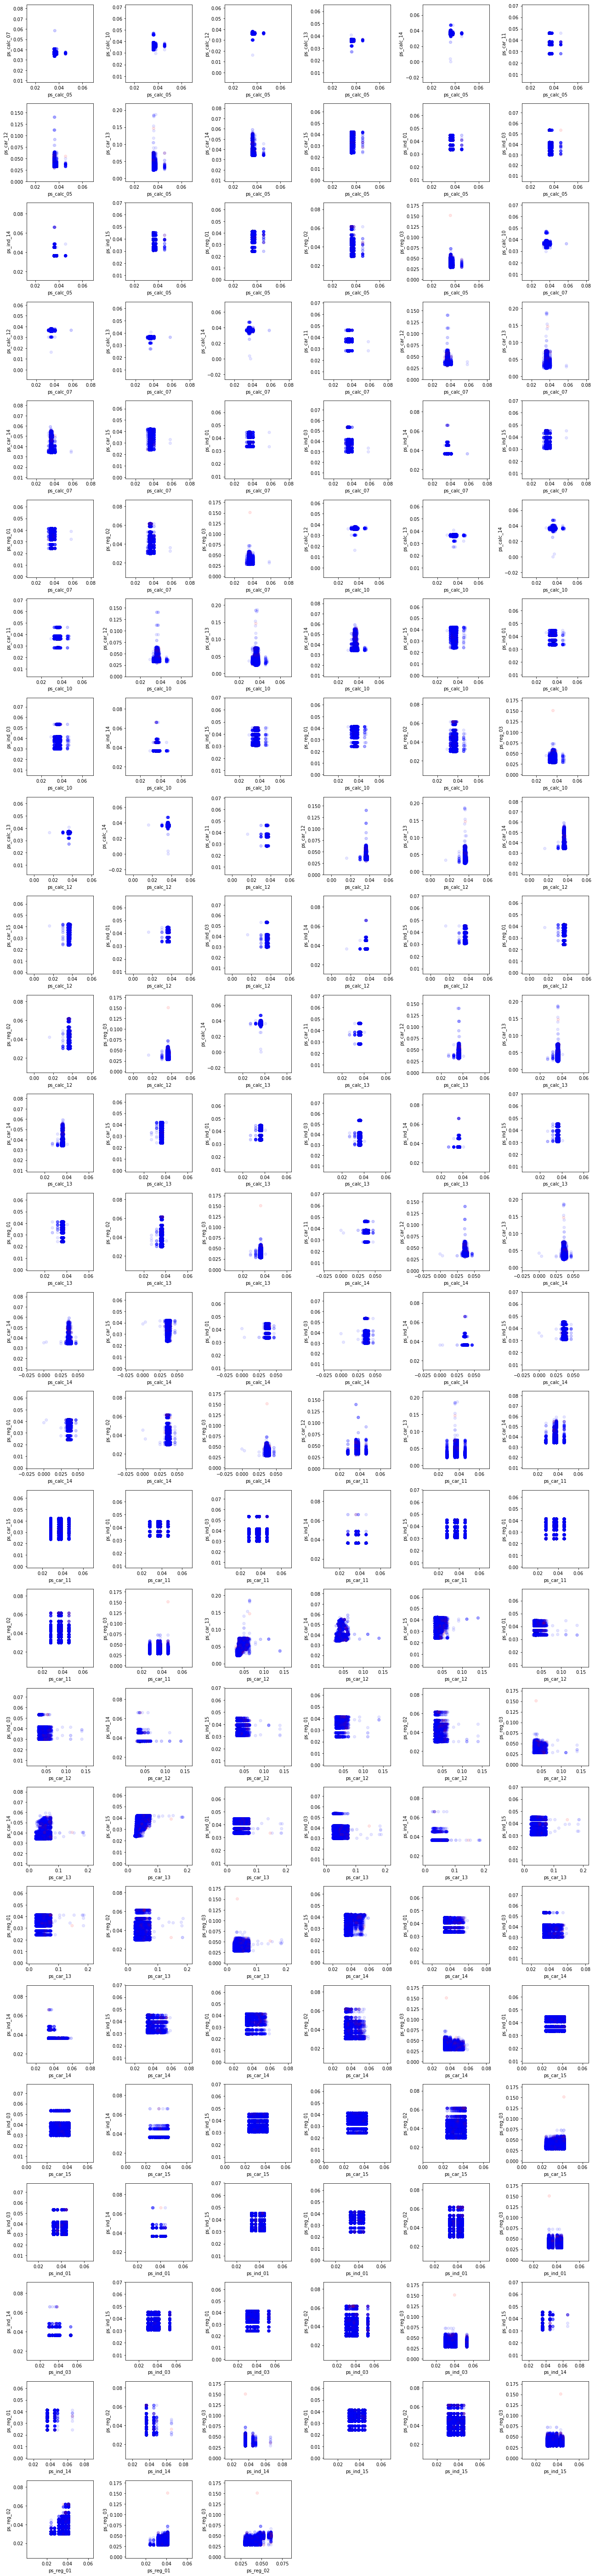

In [26]:
num_plot= 50000
fig = plt.figure(figsize=(18, 78))
for i, pair in enumerate(feature_pair_list):
    x0 = np.array(probas1[pair[0]])
    x1 = np.array(probas1[pair[1]])
    
    ax = fig.add_subplot(26, 6, i+1)
    ax.scatter(x0[:num_plot], x1[:num_plot], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
plt.tight_layout()

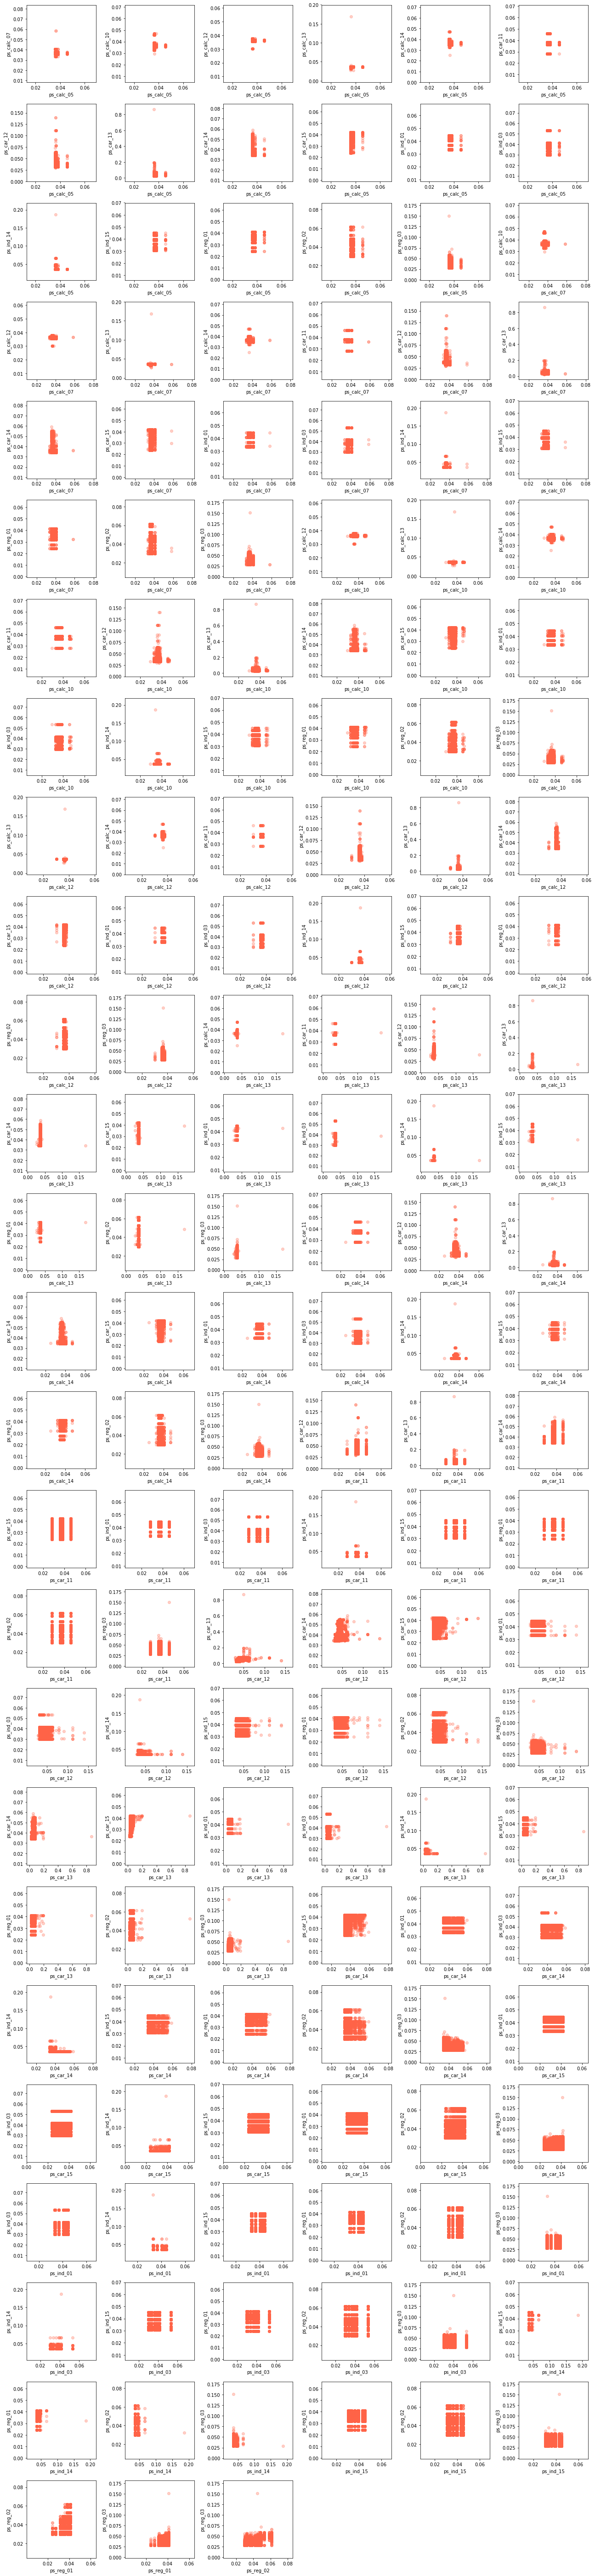

In [27]:
target_index = np.argwhere(y == 1)
num_plot= 50000
fig = plt.figure(figsize=(18, 78))
for i, pair in enumerate(feature_pair_list):
    x0 = np.array(probas1[pair[0]])
    x1 = np.array(probas1[pair[1]])
    
    ax = fig.add_subplot(26, 6, i+1)
    ax.scatter(x0[target_index], x1[target_index], color='tomato', cmap=cm.bwr, alpha=0.3)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
plt.tight_layout()

# PCA

In [18]:
y = np.array(train.target)

## Set1

In [35]:
pca1 = PCA()
Xpca1 = pca1.fit_transform(np.array(probas1))

pca_labels1 = [('component_' + str(i)) for i in range(Xpca1.shape[1])]
space1 = pd.DataFrame(Xpca1, columns=pca_labels1)

pca_pair_list1 = list(combinations(space1.columns, 2))
len(pca_pair_list1)

153

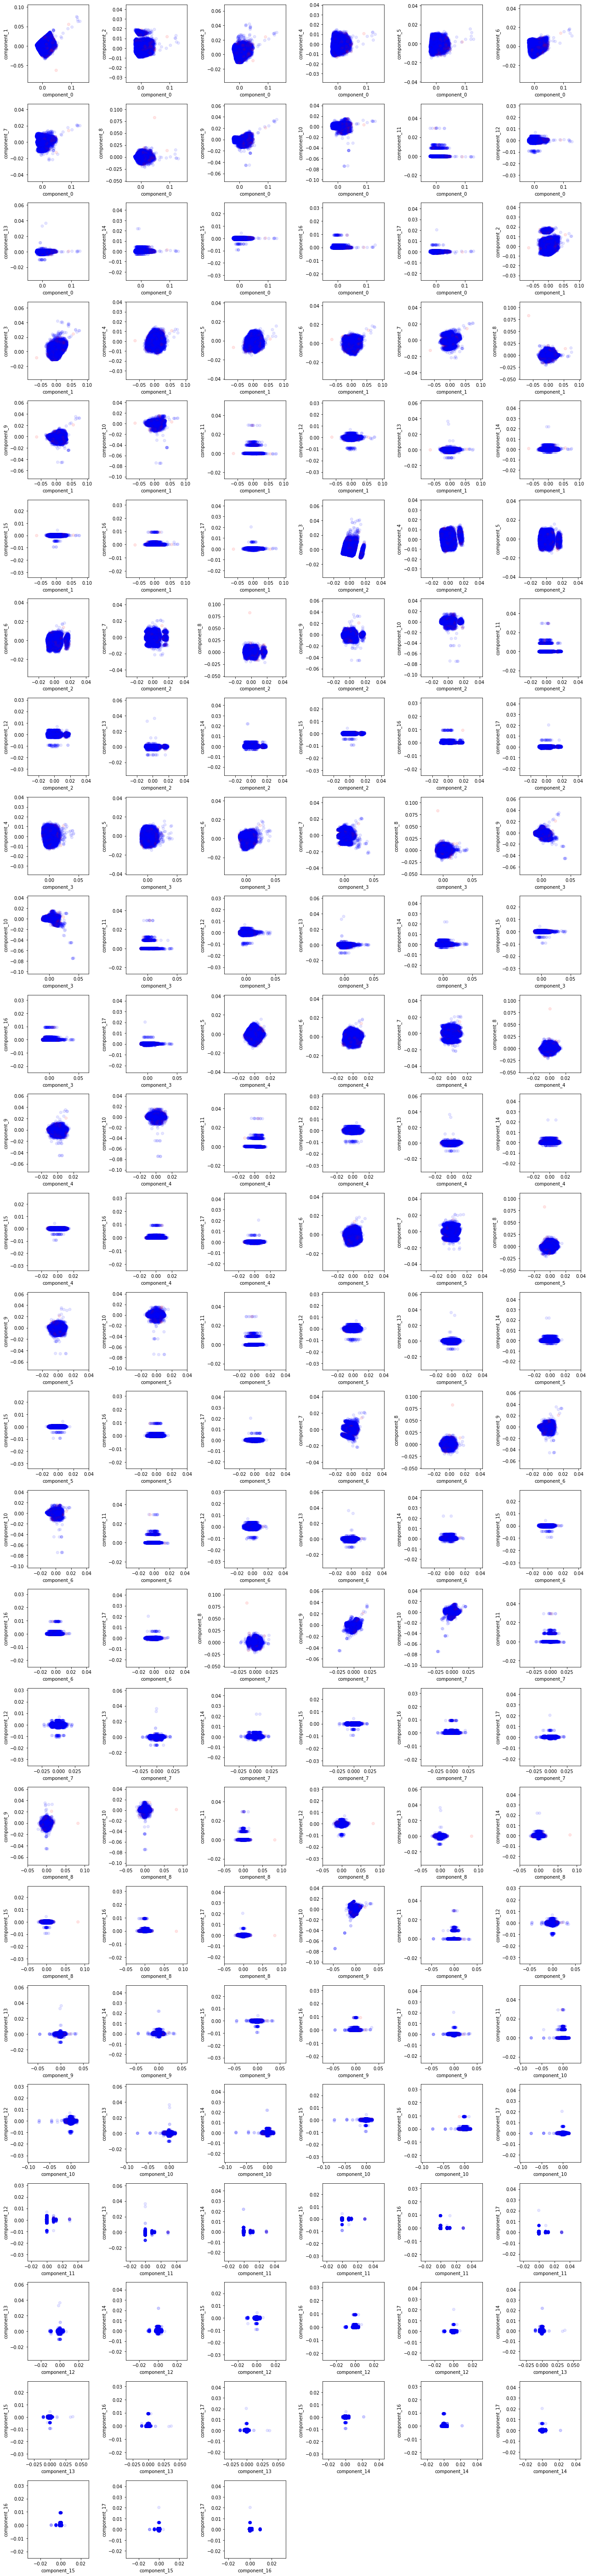

In [37]:
num_plot= 50000
fig = plt.figure(figsize=(18, 78))
for i, pair in enumerate(pca_pair_list1):
    x0 = np.array(space1[pair[0]])
    x1 = np.array(space1[pair[1]])
    
    ax = fig.add_subplot(26, 6, i+1)
    ax.scatter(x0[:num_plot], x1[:num_plot], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
plt.tight_layout()

## Set2

In [38]:
pca2 = PCA()
Xpca2 = pca2.fit_transform(np.array(probas2))

pca_labels2 = [('component_' + str(i)) for i in range(Xpca2.shape[1])]
space2 = pd.DataFrame(Xpca2, columns=pca_labels2)

pca_pair_list2 = list(combinations(space2.columns, 2))
len(pca_pair_list2)

153

In [ ]:
num_plot= 50000
fig = plt.figure(figsize=(18, 78))
for i, pair in enumerate(pca_pair_list2):
    x0 = np.array(space2[pair[0]])
    x1 = np.array(space2[pair[1]])
    
    ax = fig.add_subplot(26, 6, i+1)
    ax.scatter(x0[:num_plot], x1[:num_plot], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
plt.tight_layout()

## Set3

In [35]:
pca3 = PCA()
Xpca3 = pca3.fit_transform(np.array(probas3))

pca_labels3 = [('component_' + str(i)) for i in range(Xpca3.shape[1])]
space3 = pd.DataFrame(Xpca3, columns=pca_labels3)

pca_pair_list3 = list(combinations(space3.columns, 2))
len(pca_pair_list3)

153

In [ ]:
num_plot= 50000
fig = plt.figure(figsize=(18, 78))
for i, pair in enumerate(pca_pair_list3):
    x0 = np.array(space3[pair[0]])
    x1 = np.array(space3[pair[1]])
    
    ax = fig.add_subplot(26, 6, i+1)
    ax.scatter(x0[:num_plot], x1[:num_plot], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
plt.tight_layout()

## Set4

In [16]:
pca4 = PCA()
Xpca4 = pca4.fit_transform(np.array(probas4))

pca_labels4 = [('component_' + str(i)) for i in range(Xpca4.shape[1])]
space4 = pd.DataFrame(Xpca4, columns=pca_labels4)

pca_pair_list4 = list(combinations(space4.columns, 2))
len(pca_pair_list4)

21

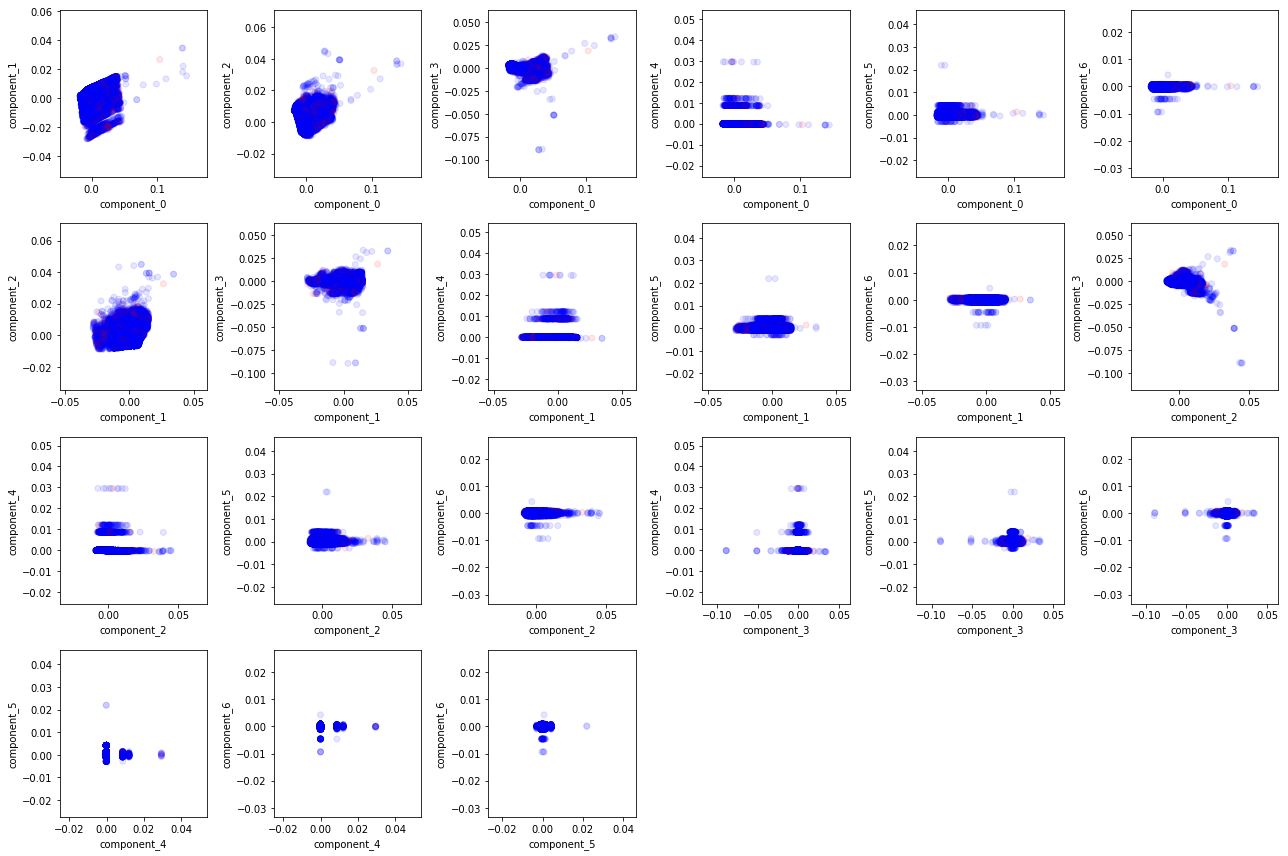

In [19]:
num_plot= 50000
fig = plt.figure(figsize=(18, 12))
for i, pair in enumerate(pca_pair_list4):
    x0 = np.array(space4[pair[0]])
    x1 = np.array(space4[pair[1]])
    
    ax = fig.add_subplot(4, 6, i+1)
    ax.scatter(x0[:num_plot], x1[:num_plot], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
plt.tight_layout()

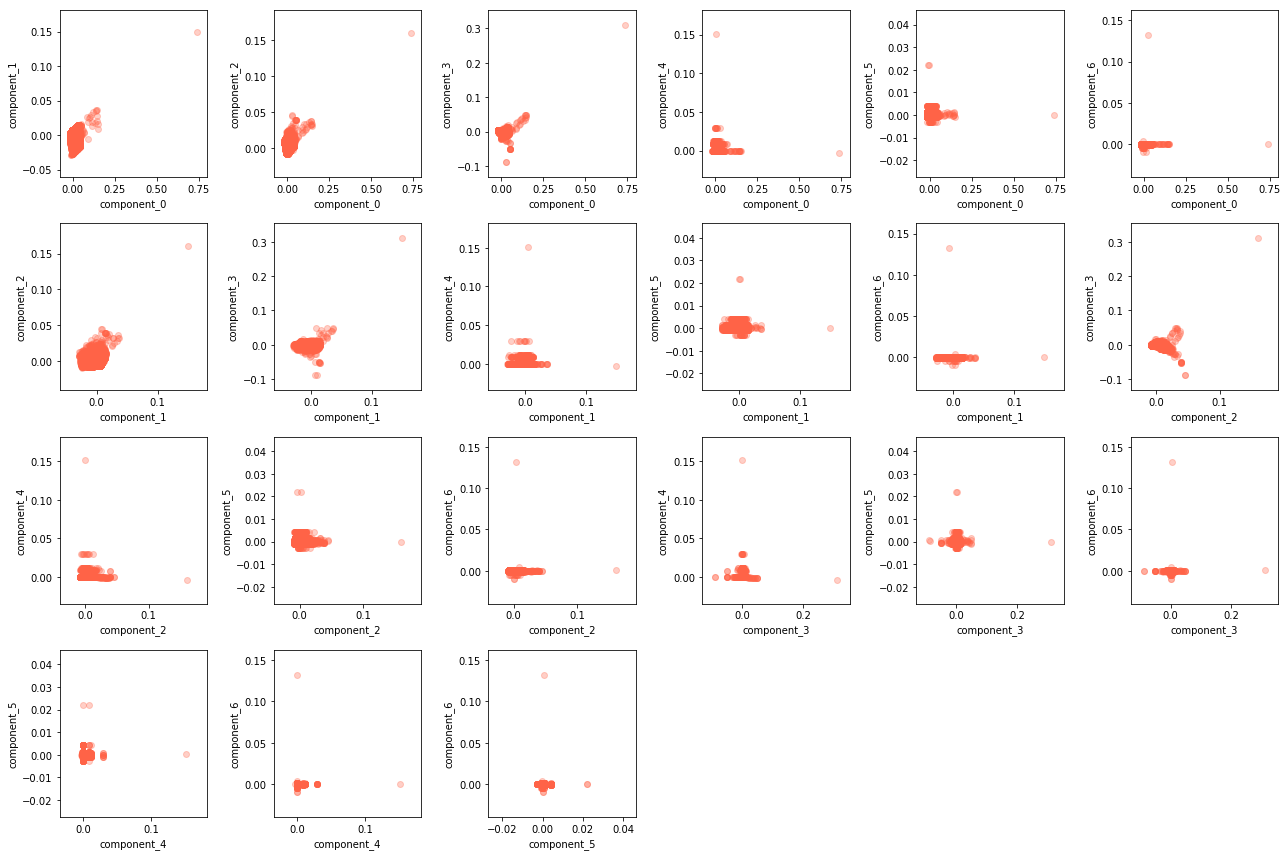

In [21]:
target_index = np.argwhere(y == 1)
fig = plt.figure(figsize=(18, 12))
for i, pair in enumerate(pca_pair_list4):
    x0 = np.array(space4[pair[0]])
    x1 = np.array(space4[pair[1]])
    
    ax = fig.add_subplot(4, 6, i+1)
    ax.scatter(x0[target_index], x1[target_index], color='tomato', alpha=0.3)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
plt.tight_layout()